In [59]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [60]:
import collections
import math
import os
import random
import zipfile

In [61]:
#file download utilities
from six.moves import urllib
from six.moves import xrange

In [62]:
import numpy as np
import tensorflow as tf


In [63]:
print(np.__version__)
print(tf.__version__)

1.14.1
1.5.0


In [64]:
DOWNLOADED_FILENAME = 'SampleText.zip'

In [65]:
def maybe_download(url_path, expected_bytes):
    if not os.path.exists(DOWNLOADED_FILENAME):
        filename, _ = urllib.request.urlretrieve(url_path, DOWNLOADED_FILENAME)
    
    statinfo = os.stat(DOWNLOADED_FILENAME)
    if statinfo.st_size == expected_bytes:
        print('Found and verified file from this path: ', url_path)
        print('Downloaded file: ', DOWNLOADED_FILENAME)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify file from: ' + url_path + '. Can you get to it from a browser?')
        
    

In [66]:
def read_words():
    with zipfile.ZipFile(DOWNLOADED_FILENAME) as f:
        firstfile = f.namelist()[0]
        filestring = tf.compat.as_str(f.read(firstfile))
        words = filestring.split()
    return words

In [67]:
URL_PATH = 'http://mattmahoney.net/dc/text8.zip'
FILESIZE = 313344016

maybe_download(URL_PATH, FILESIZE)

31344016


Exception: Failed to verify file from: http://mattmahoney.net/dc/text8.zip. Can you get to it from a browser?

In [68]:
vocabulary = read_words()

In [69]:
len(vocabulary)

17005207

In [70]:
def build_dataset(words, n_words):
    word_counts = [['UNKNOWN', -1]]
    
    counter = collections.Counter(words)
    word_counts.extend(counter.most_common(n_words-1))
    
    dictionary = dict()
    
    for word, _ in word_counts:
        dictionary[word] = len(dictionary)#assign word to the dictionary length at this step
        #the most common word gets the least index. as word_counts contains words from highest to lowest occurence
        
    word_indexes = list()
    
    unknown_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0 #dictionary['UNKNOWN]
            unknown_count += 1
        
        word_indexes.append(index)#all the words in their index form with Zero for the words except the top n_words
        
    word_counts[0][1] = unknown_count
    
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    #maps values to its coutns {1:"is", 2356: "how", 43:"this"}
    
    return word_counts, word_indexes, dictionary, reversed_dictionary


In [72]:
VOCABULARY_SIZE = 10000

In [73]:


word_counts, word_indexes, dictionary, reversed_dictionary = build_dataset(vocabulary, VOCABULARY_SIZE)


In [74]:
word_counts[:10]

[['UNKNOWN', 1737307],
 ('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430)]

In [75]:
word_indexes[:10]

[5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]

In [76]:
import random



In [77]:
for key in random.sample(list(dictionary), 10):
    print(key, ":", dictionary[key])


cover : 1291
cup : 1435
guests : 8093
precursor : 7215
producer : 1957
extend : 3871
resigned : 3999
monasteries : 8633
hits : 2951
fault : 8295


In [78]:
for key in random.sample(list(reversed_dictionary), 10):
    print(key, ":", reversed_dictionary[key])

4036 : studying
5012 : carefully
4873 : persia
3318 : keys
2927 : transition
8708 : denis
7505 : bare
4267 : tea
8127 : turner
7377 : closure


In [79]:
del vocabulary

In [80]:
#Global index into words maintained acroos batches
global_index = 0

In [81]:
def generate_batch(word_indexes, batch_size, num_skips, skip_window):
    #num_skips : the number of words we choose from a context window
    #num_skips number of words are chosen at random as target word which will be predicted using the context window center word.
    #skip_window : number of neighbors we want to consider to the left and to the right
    # if skip_window = 3 then context window contains 3 words to the left and 3 words to the right
    # The quick brown fox jumped over the lazy dog
    # if fox is center word oof the context window
    # then we pick num_skips i.e., 2 words at random to be predicted as a target word using center word "fox"
    # therefore neural network we'd set up uses  "fox" to predict -> "jumped" and "fox" -> "quick" jumped and quick are chosen at random

    global global_index # where we are in the document
    
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size,1), dtype=np.int32)
    #labels : array of arrays containing the indexes of the target predicted words
    #from the above example it would be the count of the target words, jumped and quick
    #[[1], [0], [0], ..... <batch_size>]
    
    span = 2 * skip_window + 1 # [skip_window input_word skip_window]
    #if the total size of the context window skip_window words on the left skip_wondw words on the right and the center word.
    buffer = collections.deque(maxlen = span)# double ended queue
    #very fast addition and removal of words from either ends
    
    for _ in range(span):
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes)#making sure to reset global_index back to zero once done with span items
    
    for i in range(batch_size // num_skips):
        target = skip_window #input word at the center of the buffer
        targets_to_avoid = [skip_window]
        
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span-1)
            
            targets_to_avoid.append(target)
            
            batch[i * num_skips + j] = buffer[skip_window] #this is the input word
            labels[i * num_skips + j, 0] = buffer[target] # these are the context words
        
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes)
        
    global_index = (global_index + len(word_indexes) - span) % len(word_indexes)
    
            
    return batch, labels

In [82]:
batch, labels = generate_batch(word_indexes, 10, 2, 5)

In [83]:
batch

array([   2,    2, 3134, 3134,   46,   46,   59,   59,  156,  156])

In [84]:
labels

array([[  59],
       [5234],
       [  12],
       [  59],
       [  59],
       [ 156],
       [ 195],
       [   0],
       [   0],
       [ 134]])

In [85]:
for i in range(9):
    print(reversed_dictionary[batch[i]], ":", reversed_dictionary[labels[i][0]])

of : used
of : anarchism
abuse : as
abuse : used
first : used
first : against
used : term
used : UNKNOWN
against : UNKNOWN


In [86]:
#Reset the global index backk to zero
global_index = 0

In [87]:
valid_size = 16
valid_window = 100

valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [88]:
num_samples = 64 #number of corrupted samples to be inserted

In [89]:
batch_size = 128 #128 input words fed in and their targets correspondingly
embedding_size = 50 #number of dimensions our embedding will have. that's 50 neurons in the hidden layer of the neural network
skip_window = 2
num_skips = 2

In [90]:
tf.reset_default_graph()#fresh tensorflow graph

train_inputs = tf.placeholder(tf.int32, shape=[batch_size])#every iteration = 128 bits of data fed in
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])


In [91]:
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [92]:
embeddings = tf.Variable(tf.random_uniform([VOCABULARY_SIZE, embedding_size], -1.0, 1.0))
#embeddings are generated using training data set and stored in variables 
#the shape = vocabsize:50 => every word in vocab has an embedding
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [93]:
embeddings

<tf.Variable 'Variable:0' shape=(10000, 50) dtype=float32_ref>

In [94]:
embed

<tf.Tensor 'embedding_lookup:0' shape=(128, 50) dtype=float32>

In [95]:
#the hidden layer will be setup usng a linear function with a linear equation 
# y = wx + b 
#where w is the set of weights or the weight matrix

In [96]:
# the weights and the biases are generated using the NCE module of the tensorflow Noise Contrasting Estimator
# hidden out is also not calcuated

In [97]:
nce_weights = tf.Variable(tf.truncated_normal([VOCABULARY_SIZE, embedding_size], stddev=1.0/math.sqrt(embedding_size)))

nce_biases = tf.Variable(tf.zeros([VOCABULARY_SIZE]))

In [98]:
loss = tf.reduce_mean(
    tf.nn.nce_loss(weights = nce_weights,
                  biases = nce_biases,
                  labels = train_labels,
                  inputs = embed,
                  num_sampled = num_samples,
                  num_classes = VOCABULARY_SIZE))

In [99]:
#need to be reduced. hence fed into the gradient descent optimizer with a step size of 0.1 to minimize the loss

In [100]:
optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

In [101]:
#cosine similarity is useed
#l2 norms are to be calculated first for that 
#cosine(a,b) = a.b/(||a||.||b||)
#||a|| is the l2 norm of a which is nothing but the squre root of the summ of the squares of the vector
# if a = [1 2 3] l2norm(a) = sqrt(1^2 + 2^2 + 3^2)

In [102]:
l2_norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))

normalized_embeddings = embeddings / l2_norm

In [103]:
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)

In [104]:
valid_embeddings

<tf.Tensor 'embedding_lookup_1:0' shape=(16, 50) dtype=float32>

In [105]:
normalized_embeddings

<tf.Tensor 'truediv:0' shape=(10000, 50) dtype=float32>

In [106]:
VOCABULARY_SIZE

10000

In [107]:
#gives the cosine similarity.

In [108]:
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [109]:
init = tf.global_variables_initializer()

In [110]:
num_steps = 200001

In [111]:
with tf.Session() as session:
    init.run()
    
    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(word_indexes, batch_size, num_skips, skip_window)     
        
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        
        if step%2000 == 0:
            if step > 0:
                average_loss /= 2000
                
            print('Average loss at step ', step, ':', average_loss)
            average_loss = 0
            
        #Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            
            for i in xrange(valid_size):
                valid_word = reversed_dictionary[valid_examples[i]]
                top_k = 8 # number of  nearest neighbors
                
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = 'Nearest to %s: ' % valid_word
                
                for k in xrange(top_k):
                    close_word = reversed_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
            print("\n")
        
    final_embeddings = normalized_embeddings.eval()

Average loss at step  0 : 223.0638427734375
Nearest to one:  wounded, slave, loose, essential, benedict, costume, low, regular,
Nearest to UNKNOWN:  deng, too, parent, publish, designing, batter, culture, parameter,
Nearest to however:  elsewhere, intake, application, actor, homo, exclusion, yard, contribution,
Nearest to for:  induction, focal, preparing, commodity, flexible, borne, victorian, normal,
Nearest to when:  cavalry, hill, register, narrowly, disc, intimate, definite, cgi,
Nearest to war:  deliberately, chad, distinct, kde, demon, figure, symbol, similarly,
Nearest to years:  louis, removing, per, insects, predicted, cars, libya, ibn,
Nearest to state:  recording, orthodoxy, warfare, gwh, successfully, burton, re, waters,
Nearest to as:  dust, sartre, by, miguel, team, economists, floor, shots,
Nearest to zero:  range, terrain, indus, robots, wrote, wives, tale, democracy,
Nearest to history:  gene, duty, alloy, broadly, grip, illness, launched, reducing,
Nearest to used:  

Average loss at step  52000 : 5.420434995889663
Average loss at step  54000 : 5.443281285166741
Average loss at step  56000 : 5.439289761543274
Average loss at step  58000 : 5.386469457268715
Average loss at step  60000 : 5.3027402946949005
Nearest to one:  nine, five, gas, six, australian, eight, two, zero,
Nearest to UNKNOWN:  and, a, in, too, proper, biology, groups, country,
Nearest to however:  agave, actor, elsewhere, application, effects, gore, case, form,
Nearest to for:  in, of, to, and, contemporary, UNKNOWN, on, has,
Nearest to when:  hill, register, recently, wealth, cavalry, translated, effectively, group,
Nearest to war:  western, figure, symbol, straight, avenue, became, distinct, around,
Nearest to years:  louis, cars, per, achilles, ibn, products, unknown, functions,
Nearest to state:  moon, traditional, art, vietnam, extreme, vote, sir, canonical,
Nearest to as:  by, slang, economists, team, province, brunei, on, UNKNOWN,
Nearest to zero:  two, six, wives, three, one,

Average loss at step  112000 : 4.875638140916824
Average loss at step  114000 : 4.895053794741631
Average loss at step  116000 : 4.823094380617142
Average loss at step  118000 : 4.846295726418496
Average loss at step  120000 : 4.809367312788964
Nearest to one:  nine, eight, five, six, two, three, gas, four,
Nearest to UNKNOWN:  too, proper, then, biology, and, athens, country, aspects,
Nearest to however:  agave, actor, elsewhere, application, tiny, manufactured, gore, contribution,
Nearest to for:  of, in, on, contemporary, with, and, focal, has,
Nearest to when:  hill, register, disc, cavalry, effectively, wealth, translated, recently,
Nearest to war:  chad, western, avenue, figure, straight, altitude, symbol, deliberately,
Nearest to years:  louis, removing, cars, ibn, per, achilles, unknown, predicted,
Nearest to state:  moon, recording, vietnam, extreme, warfare, traditional, programmers, vote,
Nearest to as:  slang, by, economists, brunei, team, province, contained, laser,
Neares

Average loss at step  172000 : 4.770326058387757
Average loss at step  174000 : 4.740006092429161
Average loss at step  176000 : 4.782315129518509
Average loss at step  178000 : 4.7599509383440015
Average loss at step  180000 : 4.774241248011589
Nearest to one:  nine, eight, six, five, two, three, seven, four,
Nearest to UNKNOWN:  then, proper, athens, biology, too, aspects, province, kept,
Nearest to however:  agave, elsewhere, hawaiian, application, tiny, manufactured, actor, contribution,
Nearest to for:  contemporary, of, on, focal, with, farming, similarities, mirrors,
Nearest to when:  register, hill, disc, narrowly, cavalry, effectively, translated, and,
Nearest to war:  chad, western, avenue, altitude, straight, figure, factor, defunct,
Nearest to years:  louis, removing, per, predicted, unknown, ibn, cars, complexity,
Nearest to state:  moon, recording, vietnam, extreme, programmers, warfare, traditional, vote,
Nearest to as:  slang, by, economists, brunei, team, dust, provinc

In [132]:
def save_words_embeddings(embeddings, word_counts):
    np.save('embeddings.npy', embeddings)
    
    words = [x[0] for x in word_counts]
    np.save('words.npy', words)

In [133]:
save_words_embeddings(final_embeddings, word_counts)

In [134]:
import matplotlib.pyplot as plt

In [135]:
def plot_with_labels(low_dim_embs, labels, filename = 'tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings' 
    
    plt.figure(figsize=(18,18)) #in inches
    
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        
        plt.scatter(x,y)
        
        plt.annotate(label,
                    xy = (x, y),
                    xytext = (5,2),
                    textcoords = 'offset points',
                    ha = 'right',
                    va = 'bottom')
    
    plt.savefig(filename)
    plt.show(filename)


In [136]:
from sklearn.manifold import TSNE


In [137]:
NUM_PLOT_POINTS = 500

In [138]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')

low_dim_embs = tsne.fit_transform(final_embeddings[:NUM_PLOT_POINTS, :])

labels = [reversed_dictionary[i] for i in xrange(NUM_PLOT_POINTS)]

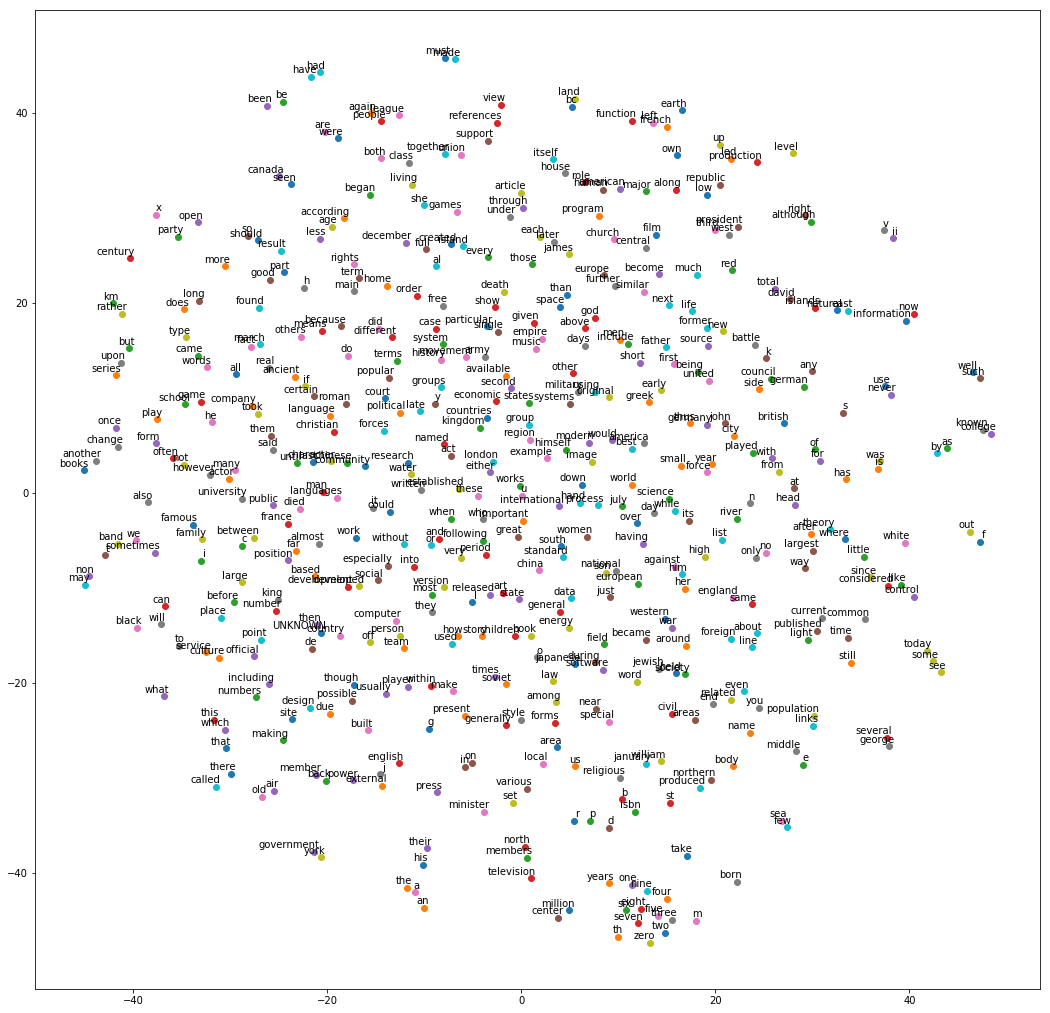

In [139]:
plot_with_labels(low_dim_embs, labels)